In [204]:
import pandas as pd
import operator


from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

%pylab inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


http://srisai85.github.io/airfoil_noise/Airfoil_Noise_Prediction.html#/

In [3]:
raw_data = pd.read_csv("airfoil_self_noise.dat.txt", sep="\t", header=None)

The NASA data set comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments.

http://airfoiltools.com/airfoil/details?airfoil=n0012-il

This problem has the following inputs: 
1. Frequency, in Hertzs. 
2. Angle of attack, in degrees. 
3. Chord length, in meters. 
4. Free-stream velocity, in meters per second. 
5. Suction side displacement thickness, in meters. 

The only output is: 
6. Scaled sound pressure level, in decibels. 

In [4]:
data = raw_data.rename(index=str, columns={0: "Freq", 1: "Angle_attack", 
                                               2: "Chord_length", 3: "Velocity", 4: "Disp_thick", 5: "Pres_level"})

In [5]:
data.head()

,Freq,Angle_attack,Chord_length,Velocity,Disp_thick,Pres_level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [6]:
import lightgbm as lgb
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV

In [7]:
nu = 15.68e-06 # Kinematic Viscosity for air at 300K (27°C) is noted as 1.568e-5
c0 = 1450
data["Re"] = data["Velocity"]*data["Chord_length"]/nu # Re = Free Stream Velocity * Characteristic Length/Kinematic Viscosity
data["St_d"] = data["Freq"]*data["Disp_thick"]/data["Velocity"]
data["St_l"] = data["Freq"]*data["Chord_length"]/data["Velocity"]
data["Dt"] = data["Disp_thick"]/data["Chord_length"]
data["Ro_d"] = data["Re"]*data["St_d"]
data["Ma"] = data["Velocity"]/c0
data["An"] = data["Angle_attack"]

In [8]:
from sklearn.preprocessing import PolynomialFeatures

In [9]:
def data_preprocess(data):
    final_data = data.copy()
    
    poly = PolynomialFeatures(degree=2)
    final_data = poly.fit_transform(final_data)
    feature_names = poly.get_feature_names()


    return final_data, feature_names

In [10]:
y = data['Pres_level']
X = data[['St_d', 'St_l', 'Ro_d', 'An', 'Dt', 'Re', 'Ma']]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=48, test_size=0.2)

In [12]:
def show_cv_reg(clf_i, name, f, l, cv, score='r2', param=None, vbs=False):
    if param: 
        grid_cv = GridSearchCV(
            clf_i,
            param,
            scoring=score,
            cv=cv,
            verbose=vbs,
            n_jobs=-1
        )
        grid_cv.fit(f, l)
        clf_i = grid_cv.best_estimator_
        print(grid_cv.best_params_)
    score = cross_val_score(clf_i,f,l,cv=cv, scoring=score, n_jobs=-1)
    print(name, score.mean(), score)

In [13]:
features, feature_names = data_preprocess(X_train)
train_feat = features
train_labels = y_train

In [21]:
features, feature_names = data_preprocess(X_test)
test_feat = features
test_labels = y_test

In [14]:
from sklearn.linear_model import  Ridge, Lasso, ElasticNet, BayesianRidge, LassoLars, LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [15]:
scaler = StandardScaler()
model_linear_reg = make_pipeline(scaler, LinearRegression())
model_ridge_reg = make_pipeline(scaler, Ridge())
model_lasso_reg = make_pipeline(scaler, Lasso())
model_elasnet_reg = make_pipeline(scaler, ElasticNet())
model_knn_reg = make_pipeline(scaler, KNeighborsRegressor())
model_bay_reg = BayesianRidge()
model_lars_reg = LassoLars()
model_rf_reg = RandomForestRegressor()
model_xgb_reg = XGBRegressor()

clfs = [
    ['Linear_reg', model_linear_reg],
    ['Ridge_reg', model_ridge_reg],
    ['Lasso_reg', model_lasso_reg],
    ['Elasnet_reg', model_elasnet_reg],
    ['KNN_reg', model_knn_reg],
    ['Bay_reg', model_bay_reg],
    ['Lars_reg', model_lars_reg],
    ['RF_reg', model_rf_reg],
    ['XGB_reg', model_xgb_reg]
]

cv = KFold(n_splits=10, shuffle=True, random_state=48).get_n_splits(train_feat,train_labels)
for name, cl in clfs:
    show_cv_reg(cl, name, train_feat, train_labels, cv)

Linear_reg 0.6765407753492998 [0.75728388 0.74504737 0.66035417 0.75265648 0.71335812 0.59536661
 0.75534111 0.49395434 0.64426201 0.64778366]
Ridge_reg 0.6846434563271744 [0.75380667 0.74449835 0.66893367 0.75546947 0.70948202 0.59624033
 0.76032088 0.55220669 0.64569444 0.65978204]
Lasso_reg 0.5564529514712084 [0.52707514 0.57151042 0.51196872 0.64432909 0.57012211 0.4712422
 0.57275788 0.58809158 0.59698628 0.51044609]
Elasnet_reg 0.5816733840115837 [0.55966791 0.60057767 0.56075381 0.66791319 0.59077224 0.49279399
 0.60339861 0.60094695 0.62030104 0.51960845]
KNN_reg 0.7896008666082973 [0.82504733 0.77046794 0.79697646 0.76566856 0.7842853  0.77535955
 0.8210193  0.7772483  0.76845356 0.81148236]
Bay_reg 0.6785762666308739 [0.7187999  0.72395882 0.6655609  0.75659742 0.67906113 0.59965869
 0.7428869  0.62891346 0.63950371 0.63082174]
Lars_reg -0.011016190409286475 [-7.75013085e-03 -5.98035698e-04 -2.61631593e-02 -4.68398720e-02
 -1.48963308e-05 -9.12371077e-04 -7.52379726e-03 -9.39

In [220]:
# function takes a RF parameter and a ranger and produces a plot and dataframe of CV scores for parameter values
def evaluate_param(clf, X, y, parameter, num_range, index):
    grid_search = GridSearchCV(clf, param_grid = {parameter: num_range}, scoring="r2", cv=10)
    grid_search.fit(X, y)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
       
    
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(4,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    return plot, df

In [221]:
param_grid = {"random_state": np.arange(1,12,1),
              "n_estimators": np.arange(2, 300, 10),
              "max_features": np.arange(0.1,1.0,0.1),
              "max_depth": np.arange(1, 28, 1),
              "min_samples_split": np.arange(2,30,2),
              "min_samples_leaf": np.arange(1,30,1),
              "max_leaf_nodes": np.arange(2,30,1),
              "min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1)
             }

In [ ]:
clf = RandomForestRegressor(n_jobs=-1)

index = 1
plt.figure(figsize=(16,16))
for parameter, param_range in dict.items(param_grid):   
    evaluate_param(clf,train_feat,train_labels,parameter,param_range,index)
    index += 1

In [ ]:
model = XGBRegressor()
 
n_estimators = [100, 200, 300, 400, 500, 1000]
learning_rate = [0.05, 0.1, 0.2, 0.3] 

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

grid_search = GridSearchCV(model, param_grid, scoring="r2", cv=10, n_jobs=-1)
grid_result = grid_search.fit(train_feat, train_labels)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    pyplot.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('R2')

In [148]:
import numpy as np
import pandas as pd

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

import xgboost as xgb

import lightgbm as lgbm

In [162]:
def objective(params):
    
    params = {'n_estimators': int(params['n_estimators']), 'max_depth': int(params['max_depth'])}
    clf = RandomForestRegressor(n_jobs=4, **params)
    
    score = cross_val_score(clf, train_feat, train_labels, scoring="mean_squared_error", cv=KFold()).mean()
    print("MSE {:.3f} params {}".format(score, params))
    return score

space = {
    'n_estimators': hp.quniform('n_estimators', 25, 500, 25),
    'max_depth': hp.quniform('max_depth', 1, 10, 1)
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

MSE -8.373 params {'n_estimators': 350, 'max_depth': 5}
MSE -9.749 params {'n_estimators': 250, 'max_depth': 4}
MSE -6.647 params {'n_estimators': 75, 'max_depth': 7}
MSE -7.307 params {'n_estimators': 75, 'max_depth': 6}
MSE -6.135 params {'n_estimators': 50, 'max_depth': 8}
MSE -6.024 params {'n_estimators': 225, 'max_depth': 8}
MSE -6.041 params {'n_estimators': 350, 'max_depth': 8}
MSE -14.371 params {'n_estimators': 50, 'max_depth': 2}
MSE -14.161 params {'n_estimators': 450, 'max_depth': 2}
MSE -8.337 params {'n_estimators': 50, 'max_depth': 5}


In [157]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = xgb.XGBRegressor(
        n_estimators=250,
        learning_rate=0.05,
        n_jobs=4,
        **params
    )
    
    score = cross_val_score(clf, train_feat, train_labels, scoring="mean_squared_error", cv=KFold()).mean()
    print("R2 {:.3f} params {}".format(score, params))
    return score

space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

R2 -3.184 params {'max_depth': 7, 'gamma': '0.200', 'colsample_bytree': '0.595'}
R2 -3.211 params {'max_depth': 7, 'gamma': '0.075', 'colsample_bytree': '0.313'}
R2 -3.331 params {'max_depth': 6, 'gamma': '0.361', 'colsample_bytree': '0.945'}
R2 -3.235 params {'max_depth': 7, 'gamma': '0.405', 'colsample_bytree': '0.384'}
R2 -3.137 params {'max_depth': 7, 'gamma': '0.409', 'colsample_bytree': '0.559'}
R2 -5.767 params {'max_depth': 2, 'gamma': '0.284', 'colsample_bytree': '0.393'}
R2 -4.395 params {'max_depth': 3, 'gamma': '0.430', 'colsample_bytree': '0.378'}
R2 -3.275 params {'max_depth': 8, 'gamma': '0.133', 'colsample_bytree': '0.986'}
R2 -3.248 params {'max_depth': 7, 'gamma': '0.298', 'colsample_bytree': '0.918'}
R2 -3.459 params {'max_depth': 4, 'gamma': '0.079', 'colsample_bytree': '0.613'}


In [158]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'colsample_bytree': 0.5587649856623876, 'gamma': 0.40917533691239155, 'max_depth': 7.0}


In [ ]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = lgbm.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.01,
        **params
    )
    
    score = cross_val_score(clf, train_feat, train_labels, scoring="mean_squared_error", cv=KFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

### Overfitting control

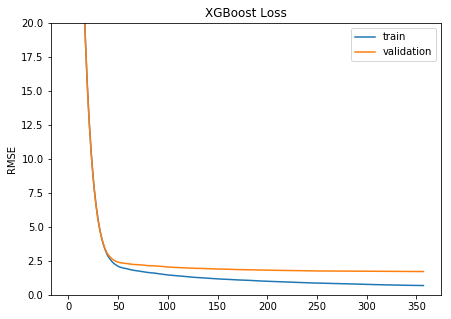

In [233]:
model = XGBRegressor(n_estimators=1000, eta=0.5)

est_feat, valid_feat, est_labels, valid_labels = train_test_split(train_feat, train_labels, test_size=0.2, random_state=48)
eval_set = [(est_feat, est_labels), (valid_feat, valid_labels)]
model.fit(est_feat, est_labels, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=10, verbose=False)
# make predictions for test data
y_pred = model.predict(valid_feat)
predictions = [round(value) for value in y_pred]
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig = plt.figure(figsize=(7,5))
plt.plot(x_axis, results['validation_0']['rmse'], label='train')
plt.plot(x_axis, results['validation_1']['rmse'], label='validation')
plt.legend()
plt.ylim([0,20])
pyplot.ylabel('RMSE')
pyplot.title('XGBoost Loss')
pyplot.show()

In [16]:
clfs = [
    ['Ridge_reg', model_ridge_reg],
    ['KNN_reg', model_knn_reg],
    ['RF_reg', model_rf_reg],
    ['XGB_reg', model_xgb_reg]
]

parameters={
    
   'Ridge_reg': {
        'ridge__alpha': np.arange(0.0001, 1.0, 0.05)
   },
    
    'KNN_reg': {
        'kneighborsregressor__n_neighbors': np.arange(5, 15, 2)
   },
    
    'RF_reg': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [8,10,12,15],
        'max_features': [0.2, 0.3, 0.5, 0.7],
        'min_samples_split': [2,5],
        'min_samples_leaf': [1,2,5],
    },
    'XGB_reg': {
        'n_estimators': [20, 50, 100, 150],
        'colsample_bytree': [0.3, 0.5, 0.7],
        'learning_rate': np.linspace(0.001, 0.5, num=20),
        'max_depth': [3,5,7]
    }
}

for name, cl in clfs:
    show_cv_reg(cl, name, train_feat, train_labels, cv, param=parameters.get(name), vbs=True)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished


{'ridge__alpha': 0.9501000000000001}
Ridge_reg 0.6844383622649581 [0.75393164 0.74451869 0.66859321 0.7554397  0.70957763 0.59619718
 0.76020338 0.55058625 0.64556212 0.65977381]
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  11 out of  50 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


{'kneighborsregressor__n_neighbors': 5}
KNN_reg 0.7896008666082973 [0.82504733 0.77046794 0.79697646 0.76566856 0.7842853  0.77535955
 0.8210193  0.7772483  0.76845356 0.81148236]
Fitting 10 folds for each of 384 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2410 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3160 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  4.5min finished


{'max_depth': 15, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RF_reg 0.91373094022226 [0.92585186 0.91834221 0.92574485 0.93612254 0.90870924 0.89593248
 0.91035731 0.93769258 0.89645079 0.88210555]
Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 2380 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3480 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 4780 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 6280 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:  1.0min finished


{'colsample_bytree': 0.5, 'learning_rate': 0.07978947368421052, 'max_depth': 7, 'n_estimators': 150}
XGB_reg 0.9466223119347623 [0.95181412 0.94754784 0.96687687 0.95439469 0.93652034 0.9492125
 0.95134363 0.95877869 0.91573981 0.93399463]


In [ ]:
final_reg_model1 = RandomForestRegressor(n_estimators=200, max_depth=15, max_features=0.3, min_samples_split=2,
                                         min_samples_leaf=1, n_jobs=5, 
                                         random_state=48)

In [ ]:
final_reg_model2 = XGBRegressor(n_estimators=150, learning_rate=0.0797, max_depth=7, colsample_bytree=0.3, random_state=48)

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
final_reg_model1.fit(train_feat, train_labels)
final_reg_model2.fit(train_feat, train_labels)

predict = []
predict.append(final_reg_model1.predict(test_feat))
predict.append(final_reg_model2.predict(test_feat))

for n, model_name in enumerate(['RF_reg', 'XGB_reg']):
    print(model_name, r2_score(test_labels, [x for x in predict[n]]))

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(test_labels, predict[0], 'ro')
plt.plot(test_labels, predict[1], 'bo')
plt.plot([105, 140], [105, 140], 'k--')

In [ ]:
feature_names = feature_names
importances = final_reg_model2.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f+1, feature_names[idx], importances[idx]))

In [ ]:
d_first = 7
plt.figure(figsize=(5,5))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

### Stacking regressor

In [243]:
from mlxtend.regressor import StackingCVRegressor


seed=48
# pipeline: tune weak regressor over cv
ridge = make_pipeline(scaler, Ridge(alpha=0.95, random_state=seed))
knn = make_pipeline(scaler, KNeighborsRegressor(n_neighbors=5))
rf = RandomForestRegressor(n_estimators=200, max_depth=15, max_features=0.3, min_samples_split=2, 
                           min_samples_leaf=1, n_jobs=-1, random_state=seed)

xgb = XGBRegressor(random_state=seed, n_jobs=-1)

# The StackingCVRegressor uses scikit-learn's check_cv
# internally, which doesn't support a random seed. Thus
# NumPy's random seed need to be specified explicitely for
# deterministic behavior
np.random.seed(seed)

stack = StackingCVRegressor(regressors=(ridge, knn, rf),
                            meta_regressor=xgb, 
                            use_features_in_secondary=True)


grid = GridSearchCV(
    
    estimator=stack, 
    
    param_grid={
        
        'meta-xgbregressor__n_estimators': [300],
        'meta-xgbregressor__learning_rate': [0.1],
         'meta-xgbregressor__colsample_bytree': [0.3, 0.5, 0.7],
          'meta-xgbregressor__max_depth': [3,5,7]
      
    }, 
    cv=5,
    refit=True,
    verbose=True,
    n_jobs=-1
)

grid.fit(train_feat, train_labels)

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
#grid.best_estimator_.predict(test_feat)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.6min finished


Best: 0.945800 using {'meta-xgbregressor__colsample_bytree': 0.5, 'meta-xgbregressor__learning_rate': 0.1, 'meta-xgbregressor__max_depth': 7, 'meta-xgbregressor__n_estimators': 300}
